# Primera entrega reto W&J
En esta primera entrega mostramos el preprocesamiento de la información, así como el análisis exploratorio de la información, métodos de corrección de los datos obtenidos y el entreno del modelo escogido. Se sigue entrenando otros modelos para mejorar la precisión del entregable. 

## 0. Cargar paquetes necesarios 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import shutil
import requests
import torch 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from PIL import Image
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import augly.image as imagus 
import torchvision.transforms as transforms


## 1. Previsualización de la información y preprocesamiento

In [2]:
data = pd.read_csv('image-Sentiment-polarity-DFE.csv')
data.keys()
# Observamos la cabecera del dataset
data.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,which_of_these_sentiment_scores_does_the_above_image_fit_into_best,which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence,imageurl,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason
0,694550568,True,golden,47,NaN,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,Highly positive\nPositive,"He is smiling. => happy, joy"
1,694550569,True,golden,36,NaN,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,Highly positive\nPositive,A beautiful scenery. => serenity
2,694550570,True,golden,35,NaN,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,Negative\nHighly negative,"They look serious. => sadness, fear"
3,694550571,True,golden,41,NaN,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,Highly positive\nPositive,"A cute puppy. => happy, joy"
4,694550572,True,golden,46,NaN,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,Highly positive\nPositive,"She looks fun. => fun, joy, happy"


In [3]:
# Verificamos si existen celdas vacias
data.isnull().sum()

_unit_id                                                                              0
_golden                                                                               0
_unit_state                                                                           0
_trusted_judgments                                                                    0
_last_judgment_at                                                                   614
which_of_these_sentiment_scores_does_the_above_image_fit_into_best                    0
which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence         0
imageurl                                                                              0
which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold           15000
which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason    15595
dtype: int64

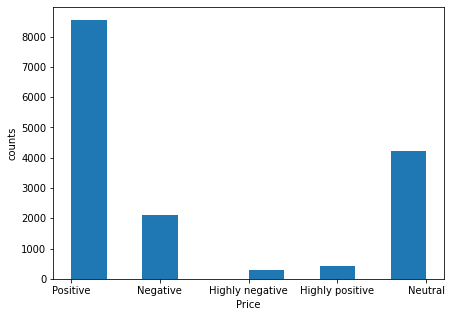

In [4]:
keys = ['_trusted_judgments', 'which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence']
Y = ['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']
#Visualizando el objetivo
data = data.astype({'which_of_these_sentiment_scores_does_the_above_image_fit_into_best': str,
                    '_last_judgment_at':str})
fig = plt.figure(figsize=(7,5))
plt.hist(data['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'])
plt.xlabel('Price')
plt.ylabel('counts')
plt.show()

In [5]:

#Eliminar los que son nan en sentimiento

data = data.dropna(subset=["which_of_these_sentiment_scores_does_the_above_image_fit_into_best"])

len(data)



15613

In [6]:
#Codificamos los features categoricos
features=data['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts().index.tolist()
data = data.astype({'which_of_these_sentiment_scores_does_the_above_image_fit_into_best': str,
                    '_trusted_judgments':float,
                    'which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence':float})
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['Positive', 'Neutral', 'Negative', 'Highly positive', 'Highly negative']])

# Ajustamos el codificador con la variable sentimiento y la transformamos
encoder.fit(data[['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']])
data['y_code'] = encoder.transform(data[['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']])

data = data.astype({'y_code': int})

In [7]:
df = pd.DataFrame()
df['unit_id'] = data['_unit_id']
df['num_like'] = data['which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence']
df['num_data'] = data['_trusted_judgments']
df['f_code'] = data['y_code']
df['f_name'] = data['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']

keys=['num_like','num_data']

len(df)

15613

In [8]:
#Verificamos la codificación de la información 
df = df.astype({'f_code': int})
code=df['f_code'].value_counts()
print(code)
name=df['f_name'].value_counts()
print('----')
print(name)

0    8551
1    4227
2    2119
3     433
4     283
Name: f_code, dtype: int64
----
Positive           8551
Neutral            4227
Negative           2119
Highly positive     433
Highly negative     283
Name: f_name, dtype: int64


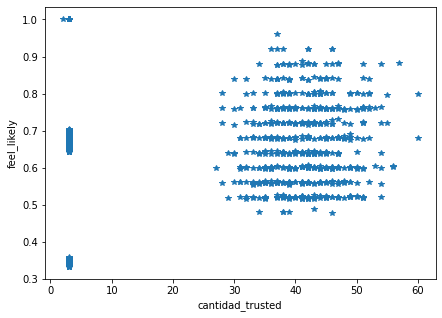

In [9]:
#-- Graficamos los puntos con sus correspondientes clases
#Clasificación Visual

fig = plt.figure(figsize=(7,5))
plt.plot(df['num_data'],df['num_like'],'*')
plt.xlabel('cantidad_trusted')
plt.ylabel('feel_likely')
plt.show()

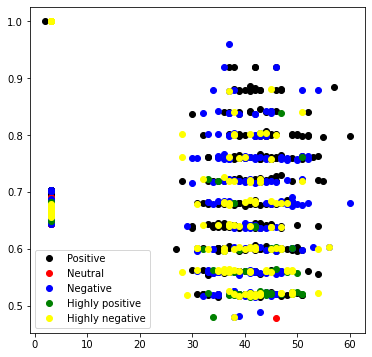

In [10]:
df= df[df['num_like'] >= 0.4]
#-- Graficamos los puntos con sus correspondientes clases
#Clasificación Visual

x1 = df['num_data']
x2 = df['num_like']
y = df['f_code']

class_0 = y == 0 # Esto es una máscara
class_1 = y == 1 # Esto es una máscara
class_2 = y == 2 # Esto es una máscara
class_3 = y == 3 # Esto es una máscara
class_4 = y == 4 # Esto es una máscara


#-- Graficamos los puntos con sus correspondientes clases
fig = plt.figure(figsize=(6,6))

plt.plot(x1[class_0],x2[class_0],'o', c='black', label='Positive ')
plt.plot(x1[class_1],x2[class_1],'o', c='red', label='Neutral ')
plt.plot(x1[class_2],x2[class_2],'o', c='blue', label='Negative ')
plt.plot(x1[class_3],x2[class_3],'o', c='green', label='Highly positive ')
plt.plot(x1[class_4],x2[class_4],'o', c='yellow', label='Highly negative')


plt.legend()
plt.show()

In [11]:
data.to_csv('data_tot.csv',encoding='utf-8') #datos con y_code
data.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,which_of_these_sentiment_scores_does_the_above_image_fit_into_best,which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence,imageurl,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason,y_code
0,694550568,True,golden,47.0,nan,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,Highly positive\nPositive,"He is smiling. => happy, joy",0
1,694550569,True,golden,36.0,nan,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,Highly positive\nPositive,A beautiful scenery. => serenity,0
2,694550570,True,golden,35.0,nan,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,Negative\nHighly negative,"They look serious. => sadness, fear",2
3,694550571,True,golden,41.0,nan,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,Highly positive\nPositive,"A cute puppy. => happy, joy",0
4,694550572,True,golden,46.0,nan,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,Highly positive\nPositive,"She looks fun. => fun, joy, happy",0


In [ ]:
#Se descargan las imagenes en una carpeta imgs
#Se capturan los nombres de las imagenes que no fue posible abrir para filtrar la información
vals = data['_unit_id'].values
boolser = data['_unit_id'].apply(lambda x:x not in vals)
df1 = data[boolser]
df1 = df1.astype({'_unit_id': str,'imageurl':str})
url=df1['imageurl'].to_numpy()
name=df1['_unit_id'].to_numpy()
unused_img=[]
len_0=len(df1)
for i in range(len_0):
    r=len_0-i
    try:
        response = requests.get(url[i], stream=True)
        with open('imgs/' + name[i]+'.jpg', 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response
        print(r,"------")
    except:
        print(r,"----------------EXEPT image: " + name[i])
        unused_img.append(name[i])
        continue
    else:
        continue

In [ ]:
#Se filtra la información y se genera la tabla data_clean.csv que tiene los datos útiles
data_bool = df1['_unit_id'].apply(lambda x:x not in unused_img)
data_fin = df1.copy()[data_bool]
data_fin.to_csv('data_clean.csv')

## 2. Tratamiento de los datos

In [ ]:
## Creamos la función multiplicar_img para compensar las clases desbalanceadas. 
data = data[['y_code','_unit_id']]
def multiplicar_img(img, data,code):
    maximo = data._unit_id.apply(lambda x :int(x)).max()
    num = int(maximo)
    lista_num = []
    j = 1
    imagen = Image.open(img)
    imagus.grayscale(imagen).save('imgs/imgs/{}.jpg'.format(num+j))
    lista_num.append(str(num+j))
    j += 1
    params_salyp = [0.45]
    for i in range(len(params_salyp)):
        imagus.shuffle_pixels(imagen, factor = params_salyp[i]).save('imgs/imgs/{}.jpg'.format(num+j), optimize=True, quality=75)
        lista_num.append(str(num+j))
        j += 1
    params_brillo = [0.45]
    for i in range(len(params_brillo)):
        imagus.brightness(imagen,factor = params_brillo[i]).save('imgs/imgs/{}.jpg'.format(num+j), optimize=True, quality=75)
        lista_num.append(str(num+j))
        j += 1
    params_sat = [0.5]
    for i in range(len(params_sat)):
        lista_num.append(str(num+j))
        imagus.saturation(imagen,factor = params_sat[i]).save('imgs/imgs/{}.jpg'.format(num+j), optimize=True, quality=75)
        j += 1
    params_noise = [0.15]
    for i in range(len(params_noise)):
        lista_num.append(str(num+j))
        imagus.random_noise(imagen, mean = params_noise[i], var = 0.3).save('imgs/imgs/{}.jpg'.format(num+j), optimize=True, quality=75)
        j += 1
    lista_code = [code for x in lista_num]
    append_data = pd.DataFrame(list(zip(lista_code,lista_num)), columns = ['y_code','_unit_id'])
    data = data.append(append_data, ignore_index = True)
    return data

In [ ]:
## Multiplicamos la cantidad de imagenes para balancear las clases
lista = data.groupby('y_code').count()['_unit_id'].values
for i in range(len(lista)):
    if (lista[i]/max(lista))<=0.8:
        dat_x = data.copy()[data['y_code']==i]
        for j in dat_x._unit_id.values:
            string = 'imgs/imgs/{}.jpg'.format(j)
            code = i
            data = multiplicar_img(string,data,code)
            
        

In [ ]:
## Creamos una tabla con la información modificada
data.to_csv('datafin.csv',index=False)

In [12]:
data = pd.read_csv('datafin.csv')

<AxesSubplot:>

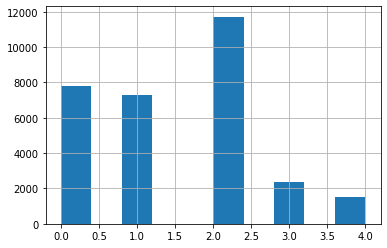

In [14]:
## Miramos que tan balanceadas quedaron las clases
data.y_code.hist()

## 3. Entreno del modelo 

In [ ]:
## Dividimos la información en el target que es y_code y las imagenes que son _unit_id
X = data['_unit_id'].copy().apply(lambda x:str(x))
y = data.copy()['y_code']
del data
X_train, X_test, y_train, y_test = train_test_split(X.values,y.values,test_size=0.2, random_state=101)
del X,y

In [ ]:
# Transformamos la información, hay que tener en cuenta que algunas fotos son a blanco y negro, por lo cual para estas
#se usa el data_transform, para las de color se usa data_transform2
data_transform = transforms.Compose([
                 transforms.Resize((299, 299)),
                 transforms.Grayscale(3),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])
data_transform2 = transforms.Compose([
                 transforms.Resize((299, 299)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [ ]:
## Creamos el dataset de entreno. Se usó solo el 25% de la información por capacidad de la máquina
X_train = X_train[0:int(len(X_train)/4)]
X_train_f = []
Y_train_f = []
for i in range(len(X_train)):
    Y_train_f.append(y_train[i]  )
    img = Image.open('imgs/imgs/'+X_train[i]+'.jpg')
    if len(np.array(img).shape) == 3: ##Aqui sabemos si la imagen es a color o a blanco y negro
        X_train_f.append( np.array(data_transform2(Image.open('imgs/imgs/'+X_train[i]+'.jpg') )))
    else:
        X_train_f.append(np.array(data_transform(Image.open('imgs/imgs/'+X_train[i]+'.jpg'))))
X_train = Variable(torch.from_numpy(np.array(X_train_f))).float()
del X_train_f
Y_train = Variable(torch.from_numpy(np.array(Y_train_f))).long()
del Y_train_f

In [ ]:
## Escogimos el modelo inception_v3 por la facilidad del manejo del modelo. 
import hiddenlayer as hl
model = torch.hub.load('pytorch/vision', 'inception_v3', pretrained=True)

In [ ]:
## Parametrizamos el entreno con un batch_size de 300 para mejorar la precisión.
## Modificamos la última capa del modelo para que tenga de salida las dimensiones que necesitamos 
batch_size = 300
train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
for p in model.parameters():
    p.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,5),
)



model.load_state_dict(model.state_dict())
del X_train, y_train
model

In [ ]:
model.train()
## Criterio de perdida y optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


## Entrenamos para 15 épocas
n_epochs = 15

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
    
    for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
        # Realizamos la predicción del batch
        Y_pred = model(X_train_batch).logits
        # Calculamos la perdida del batch
        loss = criterion(Y_pred, Y_train_batch)

        Y_pred = torch.argmax(Y_pred, 1)

        # Calculamos la precisión 
        acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iter%10 == 0:
            ## Visualizamos 
            history.log((epoch+1, iter), loss=loss, accuracy=acc)
            with canvas:
                canvas.draw_plot(history["loss"])
                canvas.draw_plot(history["accuracy"])

        iter += 1
        del X_train_batch, Y_train_batch, Y_pred
del train_dl, train_ds

In [ ]:
torch.save(model,'entrega.pt')